In [120]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
# import theano
# import theano.tensor as tt

In [121]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [122]:
df = df[:500]

<Axes: title={'center': "Wikipedia pageviews for 'Peyton Manning'"}, xlabel='ds'>

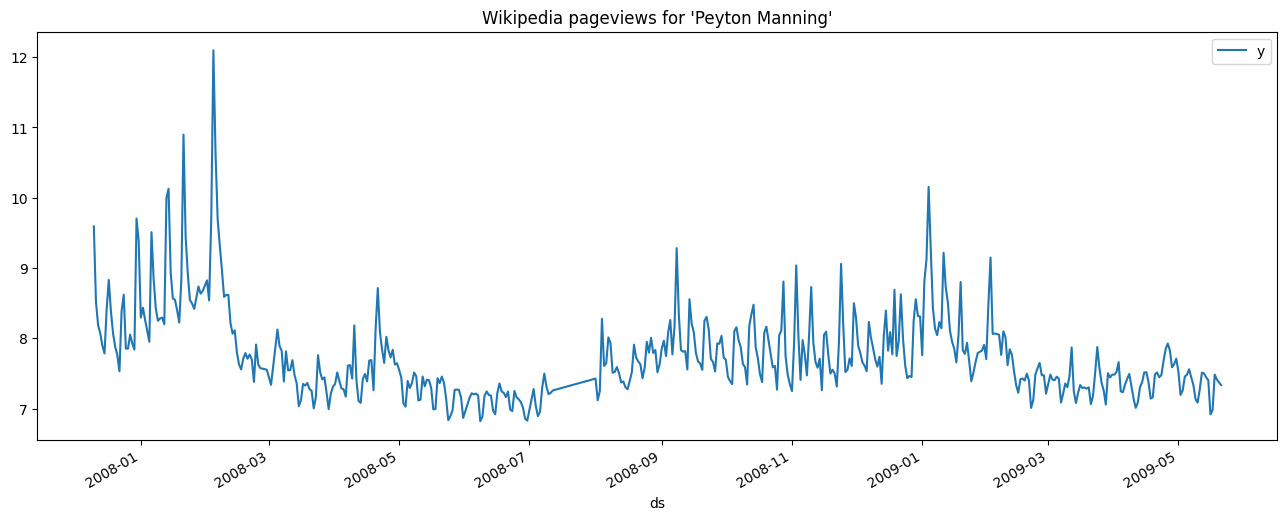

In [123]:
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

In [124]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta

        tmp = delta
        g = (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, np.array(df['t']))
    
    sigma = pm.HalfCauchy('sigma', 0.5, initval=1)
    pm.Normal('obs', 
                 mu=y,
                 sigma=sigma,
                 observed=df['y_scaled'])

Sampling: [delta, k, m, obs, sigma]


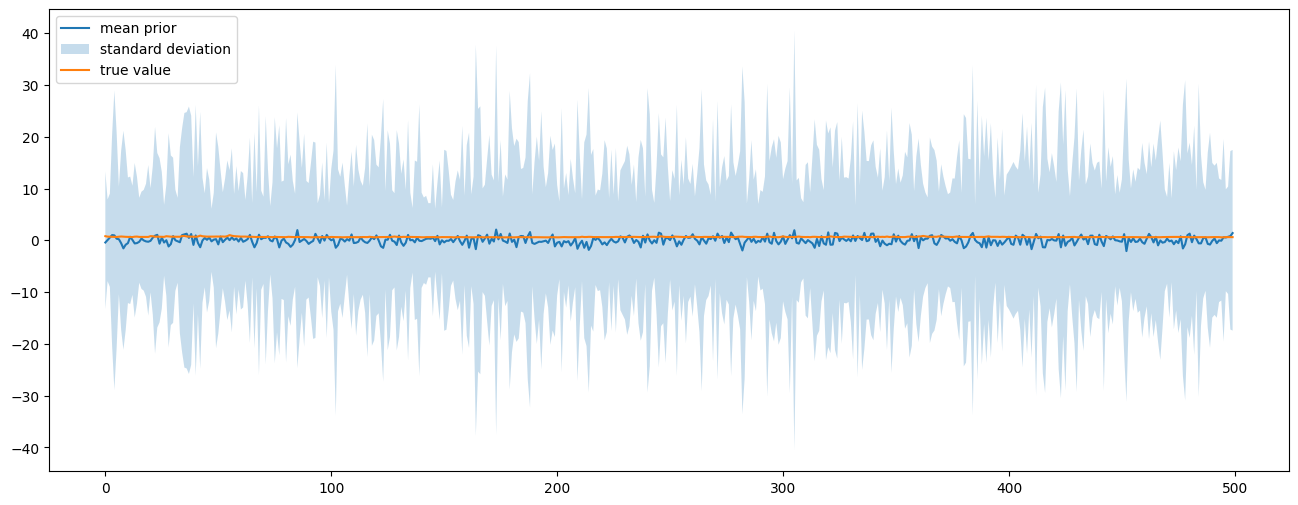

In [125]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, var_names=['obs'], return_inferencedata=False)["obs"]
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, df)

Output()

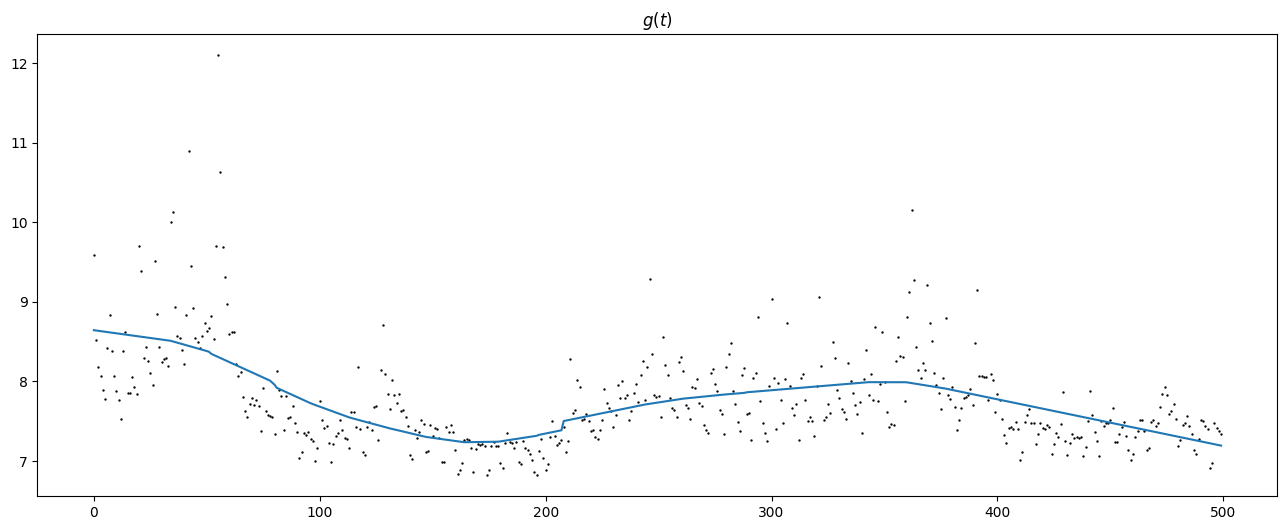

In [126]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')

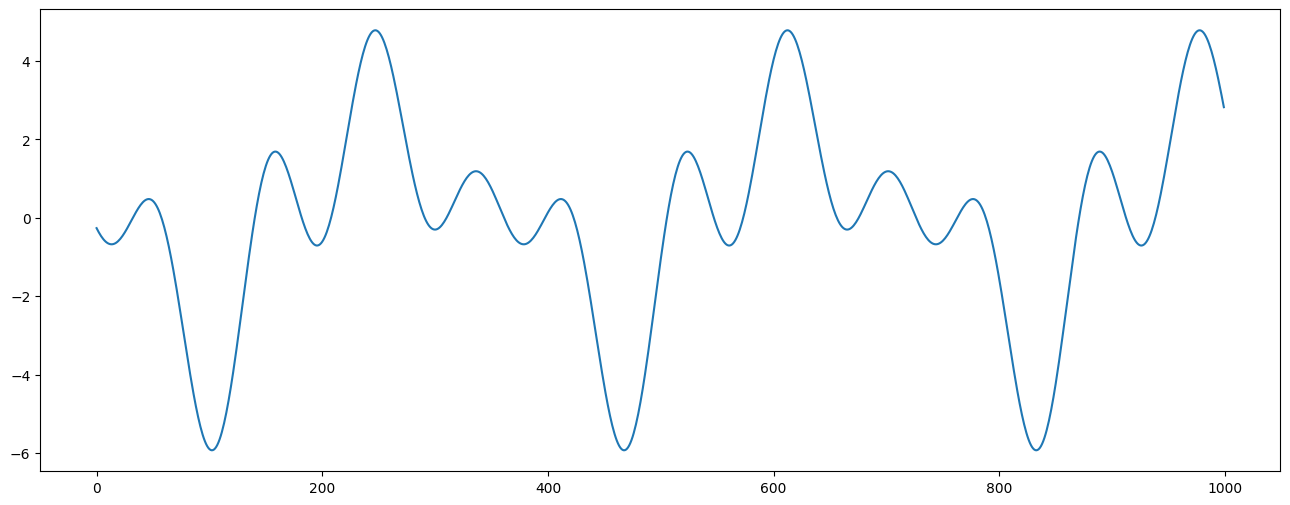

In [127]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
plt.figure(figsize=(16, 6))
plt.plot(fourier_series(t, 365.25, n) @ beta)

In [128]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['ds'].max() - df['ds'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['ds'].max() - df['ds'].min()).days
    x = fourier_series(np.array(df['t']), p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sigma=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, np.array(df['t']), changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, initval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sigma=sigma,
                 observed=df['y_scaled'])

In [133]:
with m:
    trace = pm.sample(50, chains=4, cores=4)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, tau, delta, m, beta_yearly, beta_weekly, sigma]
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=23201) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
pm.plot_trace(trace)

In [106]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = trace["posterior"]['beta_yearly']
beta_weekly = trace["posterior"]['beta_weekly']
delta = trace["posterior"]['delta']

# scalar distributions
k = trace["posterior"]['k']
m = trace["posterior"]['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['y'].max()

yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * df['y'].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * df['y'].max()

date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + yearly_posterior + weekly_posterior).mean(1), lw=0.5)
plt.scatter(date, df['y'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

ValueError: shapes (2905,25) and (25,500,4) not aligned: 25 (dim 1) != 500 (dim 1)

In [105]:
trace["posterior"]

<xarray.Dataset> Size: 884kB
Dimensions:            (chain: 4, draw: 500, delta_dim_0: 25,
                        beta_yearly_dim_0: 20, beta_weekly_dim_0: 6)
Coordinates:
  * chain              (chain) int64 32B 0 1 2 3
  * draw               (draw) int64 4kB 0 1 2 3 4 5 ... 494 495 496 497 498 499
  * delta_dim_0        (delta_dim_0) int64 200B 0 1 2 3 4 5 ... 20 21 22 23 24
  * beta_yearly_dim_0  (beta_yearly_dim_0) int64 160B 0 1 2 3 4 ... 16 17 18 19
  * beta_weekly_dim_0  (beta_weekly_dim_0) int64 48B 0 1 2 3 4 5
Data variables:
    k                  (chain, draw) float64 16kB 0.8157 0.8157 ... 0.5717
    delta              (chain, draw, delta_dim_0) float64 400kB -0.03966 ... ...
    m                  (chain, draw) float64 16kB 0.5267 0.5267 ... 0.5639
    beta_yearly        (chain, draw, beta_yearly_dim_0) float64 320kB 0.05563...
    beta_weekly        (chain, draw, beta_weekly_dim_0) float64 96kB 0.01387 ...
    tau                (chain, draw) float64 16kB 0.2532 0.2532 ... 0.2106
    sigma              (chain, draw) float64 16kB 0.04326 0.04326 ... 0.04134
Attributes:
    created_at:                 2024-11-22T18:19:52.372697+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.18.2
    sampling_time:              77.91442394256592
    tuning_steps:               1000

In [107]:
A.shape, delta.shape

((2905, 25), (4, 500, 25))

In [108]:
delta

<xarray.DataArray 'delta' (chain: 4, draw: 500, delta_dim_0: 25)> Size: 400kB
array([[[-0.03965977, -0.04268241, -0.14878625, ..., -1.14590505,
         -0.14528735,  0.62249726],
        [-0.03965977, -0.04268241, -0.14460847, ..., -1.14590505,
         -0.14528735,  0.62249726],
        [-0.03965977, -0.04268241, -0.14460847, ..., -1.14590505,
         -0.14528735,  0.62249726],
        ...,
        [-0.07623199, -0.07517977, -0.17494273, ..., -1.1475771 ,
         -0.01925038,  0.28698867],
        [-0.07676131, -0.07517977, -0.17494273, ..., -1.1475771 ,
         -0.01925038,  0.28698867],
        [-0.07676131, -0.07517977, -0.17494273, ..., -1.12268318,
         -0.01925038,  0.29837753]],

       [[-0.09778575,  0.29610128,  0.52615569, ...,  0.52626212,
         -1.25839289,  0.32557451],
        [-0.09778575,  0.29610128,  0.52615569, ...,  0.52626212,
         -1.26594879,  0.32557451],
        [-0.09778575,  0.29610128,  0.52499193, ...,  0.52934333,
         -1.26594879,  0.32557451],
...
        [-0.05143863,  0.02324797, -0.01981299, ..., -0.86189783,
          0.37623064, -0.16274535],
        [-0.05143863,  0.02324797, -0.01981299, ..., -0.86189783,
          0.37623064, -0.16274535],
        [-0.05143863,  0.02324797, -0.0215467 , ..., -0.86189783,
          0.37118947, -0.16274535]],

       [[-0.09186071,  0.09280702, -0.29919403, ..., -0.39541653,
          0.15015141, -0.17503963],
        [-0.09186071,  0.09280702, -0.29919403, ..., -0.39541653,
          0.15015141, -0.17503963],
        [-0.09215629,  0.09280702, -0.29919403, ..., -0.39541653,
          0.15015141, -0.17503963],
        ...,
        [-0.13397508,  0.05150761, -0.31590797, ..., -0.34277513,
          0.01758433, -0.07939886],
        [-0.13397508,  0.05150761, -0.31590797, ..., -0.34277513,
          0.01758433, -0.07939886],
        [-0.13397508,  0.05150761, -0.31590797, ..., -0.34277513,
         -0.01267238, -0.07939886]]])
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * delta_dim_0  (delta_dim_0) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24